<a href="https://colab.research.google.com/github/DavidToth23/music_instrument_classification/blob/main/fourth_phase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files
uploaded = files.upload()

Saving nsynth-valid.jsonwav.tar.gz to nsynth-valid.jsonwav.tar.gz


In [5]:
import tarfile

with tarfile.open("nsynth-valid.jsonwav.tar.gz", "r:gz") as tar:
    tar.extractall("nsynth-valid")

/tmp/ipython-input-4291929459.py:4: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall("nsynth-valid")


In [6]:
import os

print(os.listdir("nsynth-valid")[:10])


['nsynth-valid']


In [7]:
import json, os
from pathlib import Path
import pandas as pd

SPLIT_DIR = Path("nsynth-valid/nsynth-valid")
META_PATH = SPLIT_DIR / "examples.json"

# map porodica (family_id -> ime)
FAMILY_MAP = {
    0: "bass", 1: "brass", 2: "flute", 3: "guitar", 4: "keyboard",
    5: "mallet", 6: "organ", 7: "reed", 8: "string", 9: "synth_lead", 10: "vocal"
}

with open(META_PATH, "r") as f:
    meta = json.load(f)

rows = []
for key, m in meta.items():
    rel = m.get("audio_path")
    if not rel:
        cand = list((SPLIT_DIR / "audio").rglob(f"{key}.wav"))
        if not cand:
            continue
        rel = cand[0].relative_to(SPLIT_DIR).as_posix()

    rows.append({
        "id": key,
        "wav": str((SPLIT_DIR / rel).resolve()),
        "family_id": int(m["instrument_family"]),
        "family": FAMILY_MAP[int(m["instrument_family"])],
        "pitch": int(m["pitch"]),
        "velocity": int(m["velocity"])
    })

df = pd.DataFrame(rows)
df.head(), df["family"].value_counts().sort_index()


(                                id  \
 0    keyboard_acoustic_004-060-025   
 1       bass_synthetic_033-050-100   
 2       bass_synthetic_009-052-050   
 3  keyboard_electronic_003-064-127   
 4       bass_synthetic_034-030-050   
 
                                                  wav  family_id    family  \
 0  /content/nsynth-valid/nsynth-valid/audio/keybo...          4  keyboard   
 1  /content/nsynth-valid/nsynth-valid/audio/bass_...          0      bass   
 2  /content/nsynth-valid/nsynth-valid/audio/bass_...          0      bass   
 3  /content/nsynth-valid/nsynth-valid/audio/keybo...          4  keyboard   
 4  /content/nsynth-valid/nsynth-valid/audio/bass_...          0      bass   
 
    pitch  velocity  
 0     60        25  
 1     50       100  
 2     52        50  
 3     64       127  
 4     30        50  ,
 family
 bass        2638
 brass        886
 flute        470
 guitar      2081
 keyboard    2404
 mallet       663
 organ       1598
 reed         720
 string  

In [8]:

mini = df.copy()  # uzmi ceo split bez seckanja

mini["family"].value_counts().sort_index()
mini.to_csv("nsynth_mini.csv", index=False)


In [9]:
!pip -q install torch torchaudio librosa soundfile --upgrade

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import librosa

SR = 16000
N_FFT = 1024
HOP = 256
N_MELS = 64
FMIN = 20
FMAX = 8000

LABELS = sorted(mini["family"].unique())
label2idx = {l:i for i,l in enumerate(LABELS)}
idx2label = {i:l for l,i in label2idx.items()}

class NSynthMelDataset(Dataset):
    def __init__(self, table, augment=False):
        self.table = table.reset_index(drop=True)
        self.augment = augment

    def __len__(self):
        return len(self.table)

    def __getitem__(self, i):
        row = self.table.iloc[i]
        wav_path = row["wav"]
        y, sr = librosa.load(wav_path, sr=SR, mono=True)
        if self.augment:
            gain = 10**(np.random.uniform(-3,3)/20)
            y = y * gain

        S = librosa.feature.melspectrogram(
            y=y, sr=SR, n_fft=N_FFT, hop_length=HOP,
            n_mels=N_MELS, fmin=FMIN, fmax=FMAX
        )
        S_db = librosa.power_to_db(S, ref=np.max).astype(np.float32)
        mu, sigma = S_db.mean(), S_db.std() + 1e-6
        S_norm = (S_db - mu) / sigma
        # PyTorch očekuje [C, H, W]
        x = torch.from_numpy(S_norm).unsqueeze(0)  # [1, n_mels, time]
        y_lbl = torch.tensor(label2idx[row["family"]], dtype=torch.long)
        return x, y_lbl


In [10]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(mini, test_size=0.2, stratify=mini["family"], random_state=42)
train_ds = NSynthMelDataset(train_df, augment=True)
val_ds   = NSynthMelDataset(val_df, augment=False)

from torch.utils.data import WeightedRandomSampler

# Izračunaj broj primera po klasi
class_counts = train_df["family"].value_counts().to_dict()

# Težina svakog primera je obrnuto proporcionalna broju primera klase
weights = [1.0 / class_counts[row["family"]] for _, row in train_df.iterrows()]
weights = torch.DoubleTensor(weights)

sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# DataLoader sa sampler-om umesto shuffle
train_dl = DataLoader(train_ds, batch_size=32, sampler=sampler, num_workers=2, pin_memory=True)

val_dl   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds), LABELS


(10142,
 2536,
 ['bass',
  'brass',
  'flute',
  'guitar',
  'keyboard',
  'mallet',
  'organ',
  'reed',
  'string',
  'vocal'])

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeepCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2),
        )

        self.gap = nn.AdaptiveAvgPool2d((1,1))   # global average pooling
        self.fc1 = nn.Linear(256, 128)
        self.drop_fc = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.drop_fc(x)
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepCNN(n_classes=len(LABELS)).to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480><function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()
self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
     if w.is_alive():  
    Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>    
^ Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480> Traceback (most recent 

Ep 1: train loss 1.480 acc 0.439 | val loss 1.216 acc 0.542


  0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>^^
^^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^self._shutdown_workers()^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():^^
^ ^ ^ ^ ^ ^ ^ ^^^

  0%|          | 0/80 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

Traceback (most recent call last):
    self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
self._shutdown_workers()    
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
if w.is_alive():
     if w.is_alive():
            ^ ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python

Ep 2: train loss 0.768 acc 0.700 | val loss 0.772 acc 0.732


  0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>    self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    if w.is_alive():    
self._shutdown_workers() 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
       if w.is_alive(): 
    ^^^ ^^ ^^ ^ ^ ^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>
self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-pack

  0%|          | 0/80 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480><function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()
self._shutdown_workers()Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    
<function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>if w.is_alive():

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
       Exception ignored in: Traceback (most recent call last):
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>  File "/usr/loca

Ep 3: train loss 0.463 acc 0.824 | val loss 0.440 acc 0.875


  0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>^^

Traceback (most recent call last):

  File "/usr/lib/python3.12/multiprocessing/process.p

  0%|          | 0/80 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>    
if w.is_alive():Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 166

Ep 4: train loss 0.302 acc 0.890 | val loss 0.313 acc 0.915


  0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        if w.is_alive():if w.is_alive():

             ^ ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: 
 

  0%|          | 0/80 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480><function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  
          ^ ^ ^^^^^^^^^^^Exception ignored in: ^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>^
^^^Traceback (most recent call last):
^
  File "/usr/local/lib/python3.12/dist-packages/torch/uti

Ep 5: train loss 0.249 acc 0.911 | val loss 0.264 acc 0.940


  0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    
self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    if w.is_alive():
      self._shutdown_workers() 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
     if w.is_alive():  
  ^ ^  ^ ^^ ^ ^^^^^^^^^^^^
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^  Exception ignored in:

  0%|          | 0/80 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        if w.is_alive():
if w.is_alive():
           ^^ ^^^^^Exception ignored in: ^ ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480> 
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dat

Ep 6: train loss 0.190 acc 0.936 | val loss 0.214 acc 0.953


  0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480><function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
     if w.is_alive(): 
      Exception ignored in:    <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>^
 ^Exception ignored in: Traceback (most recent call last):
 ^  File "/usr/local/lib/python3.12/dist-packages/torch/u

  0%|          | 0/80 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480><function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Traceback (most recent call last):
        if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Exceptio

Ep 7: train loss 0.173 acc 0.939 | val loss 0.177 acc 0.972


  0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
     Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480> 
^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^^self._shutdown_workers()^
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():^
^^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
       assert self._parent_pid == os.getpid(), 'can only test a child process' 
  ^^  ^ ^  ^^  ^ ^ ^ Exception ignore

  0%|          | 0/80 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480><function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

    self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()

    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
       if w.is_alive():
    ^ ^ ^ ^ ^ ^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: ^    <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>^assert se

Ep 8: train loss 0.116 acc 0.964 | val loss 0.098 acc 0.981


  0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480><function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()
self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
if w.is_alive():    
if w.is_alive(): 
           ^ ^ ^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        assert self.

  0%|          | 0/80 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
if w.is_alive():    
if w.is_alive(): 
           ^  ^^^^^^^^^^^^^^^^^^^^
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>
assert

Ep 9: train loss 0.116 acc 0.963 | val loss 0.133 acc 0.972


  0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

Traceback (most recent call last):
    self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

    self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
if w.is_alive():
      if w.is_alive(): 
         ^ ^ ^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self.

  0%|          | 0/80 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480><function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
self._shutdown_workers()    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
if w.is_alive():    if w.is_alive():
 
            ^^ ^^^^^^^^^^^^^^^^^^Exception ignored in: ^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>

^
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/process.p

Ep 10: train loss 0.102 acc 0.965 | val loss 0.127 acc 0.971


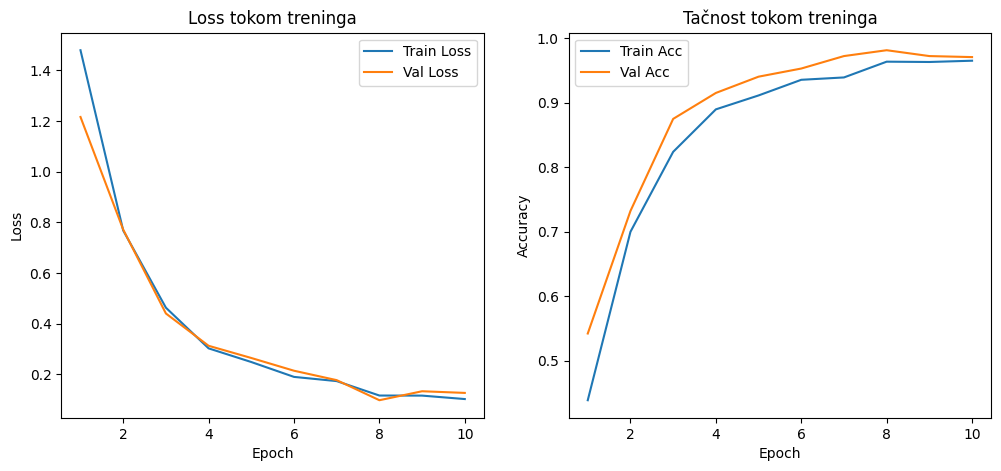

In [12]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

train_losses, val_losses = [], []
train_accs, val_accs = [], []

def run_epoch(dl, train=True):
    model.train(train)
    total, correct, loss_sum = 0, 0, 0.0
    for xb, yb in tqdm(dl, leave=False):
        xb, yb = xb.to(device), yb.to(device)
        if train:
            opt.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        if train:
            loss.backward()
            opt.step()
        loss_sum += loss.item() * yb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return loss_sum/total, correct/total

EPOCHS = 10
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_dl, train=True)
    va_loss, va_acc = run_epoch(val_dl, train=False)

    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(va_loss)
    val_accs.append(va_acc)

    print(f"Ep {ep}: train loss {tr_loss:.3f} acc {tr_acc:.3f} | "
          f"val loss {va_loss:.3f} acc {va_acc:.3f}")

# sačuvaj model
torch.save({"state_dict": model.state_dict(), "labels": LABELS}, "nsynth_cnn_baseline.pt")

# --- crtanje grafova ---
epochs = range(1, EPOCHS+1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss tokom treninga")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Tačnost tokom treninga")
plt.legend()

plt.show()

In [13]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# skupi sve predviđanja na validation
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(1).cpu().numpy()
        y_pred.extend(preds.tolist())
        y_true.extend(yb.numpy().tolist())

print(classification_report(y_true, y_pred, target_names=LABELS))
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(LABELS))))
cm


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
Exception ignored in:   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7cfd6430e480>    assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
       if w.is_alive(): 
     ^ ^ ^ ^  ^^^^^^^^^^^^^^^^^^^^^

              precision    recall  f1-score   support

        bass       0.95      0.98      0.97       528
       brass       1.00      0.98      0.99       177
       flute       1.00      1.00      1.00        94
      guitar       0.96      0.95      0.95       416
    keyboard       0.98      0.94      0.96       481
      mallet       0.94      0.96      0.95       132
       organ       1.00      0.99      1.00       320
        reed       0.97      1.00      0.98       144
      string       0.95      0.97      0.96       163
       vocal       1.00      1.00      1.00        81

    accuracy                           0.97      2536
   macro avg       0.97      0.98      0.98      2536
weighted avg       0.97      0.97      0.97      2536



array([[520,   0,   0,   0,   0,   8,   0,   0,   0,   0],
       [  0, 174,   0,   0,   0,   0,   0,   3,   0,   0],
       [  0,   0,  94,   0,   0,   0,   0,   0,   0,   0],
       [ 12,   0,   0, 396,   5,   0,   0,   0,   3,   0],
       [  6,   0,   0,  18, 450,   0,   0,   2,   5,   0],
       [  4,   0,   0,   0,   1, 127,   0,   0,   0,   0],
       [  0,   0,   0,   0,   2,   0, 318,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 144,   0,   0],
       [  5,   0,   0,   0,   0,   0,   0,   0, 158,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  81]])